# Identifying Best Content for Stack Exchange 
**Goal**: From the perspective of a content creator for data science, identify what is the "best" content to write about using information from the Data Science Stack Exchange (DSSE), which is a host site on Stack Exchange. Secondly, define what "best" content means.

## Part II - Stack Exchange
- All questions relating to the field are welcomed on the site, mainly technical
- Along with questions the site's home subdivides into Tags, Users and Unanswered
- Under the question tab, there is an option to list the most frequent or voted questions, which can help identify what the most popular content is about
- Under the unanswered tab, there is a filter that contains questions with no answers, but still has votes - this can be useful because this means the answers are desired, but no one has answered it possibly because it is new, it is a difficult problem, etc.
- Information available in each post includes questions, comments, answers, votes, tags and etc.

## Part III - Stack Exchange Data Explorer
- [Link](https://data.stackexchange.com/datascience/query/new) to query and explore Data Science Stack Exchange's databadse using Stack Exchange Data Explorer (SEDE) and SQL Server
- Tables and specific featurs that look more promising towards finding the most popular content are: 
    - **Table**: Posts **Features**: ViewCount, Tags
    - **Table**: PostTags **Features**: PostID, TagID
    - **Table**: Tags **Features**: TagName, Count
    - **Table**: TagSynonyms **Features**: SourceTagName, TargetTagName

## Part IV - Getting the Data
- Focus on following features for Posts table: 
    - Id: identification number for the post
    - PostTypeId: identification number for the type of post
    ![posttypeid](https://dq-content.s3.amazonaws.com/469/PostTypes.png)
    - CreationDate: The date and time of creation of the post
    - Score: The post's [score](https://meta.stackoverflow.com/questions/280818/how-are-tag-scores-calculated) (upvotes - downvotes)
    - ViewCount: How many times the post was viewed
    - Tags: What tags were used
    - AnswerCount: How many answers the question got (only applicable to question posts)
    - FavoriteCount: How many times the question was [favored](https://meta.stackexchange.com/questions/53585/how-do-question-bookmarks-work) (only applicable to question posts)

- In order to understand the popularity of the 8 different types of. posts indicated in PostTypeId the following query was run:
        `SELECT PostTypeId, COUNT(*) as NrOfPosts
        FROM Posts
        GROUP BY PostTypeID;'
    - The results showed that the most popular were questions and answers. Here the focus will be on questions and those that are recent (2019 posts)
    
- Ran following query against the SEDE DSSE database to extract the columns listed above for all the questions in 2019:
        `SELECT Id, PostTypeId, CreationDate, Score, ViewCount, Tags, AnswerCount, FavoriteCount
        FROM Posts
        WHERE YEAR(CreationDate) = 2019
        AND PostTypeId = 1;'

## Part V - Exploring the Data
- The results of the query were stored in a file called 2019_questions.csv

**Read in the file into a dataframe**

In [1]:
import pandas as pd
df = pd.read_csv('2019_questions.csv', parse_dates = ['CreationDate'])
df.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,44419,2019-01-23 09:21:13,1,21,<machine-learning><data-mining>,0,NaN
1,44420,2019-01-23 09:34:01,0,25,<machine-learning><regression><linear-regressi...,0,NaN
2,44423,2019-01-23 09:58:41,2,1651,<python><time-series><forecast><forecasting>,0,NaN
3,44427,2019-01-23 10:57:09,0,55,<machine-learning><scikit-learn><pca>,1,NaN
4,44428,2019-01-23 11:02:15,0,19,<dataset><bigdata><data><speech-to-text>,0,NaN


** Determine:**
- **how many missing values are in each column**

In [2]:
print('number of entries: {}'.format(df.shape[0]))
df.isnull().sum()

number of entries: 8839


Id                  0
CreationDate        0
Score               0
ViewCount           0
Tags                0
AnswerCount         0
FavoriteCount    7432
dtype: int64

 - **how to fix the missing values**
 
 The only column that has missing values is `FavoriteCount` and seeing as the that is nearly 85% of the entries, two solutions is:
 
 1) assume that null values are 0. The null values most likely means that no user favored it and therefore it is a null value
 
 2) delete the column seeing as that only 15% of the entries has a value for the feature

- **if the types of each column are adequate**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    1407 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB


- the types for each column all seem to be adequate:
    - the object type is Tag which is a string
    - the datetime type is CreationDate which is a date that was [parsed when the csv was imported as a pandas dataframe](https://honingds.com/blog/pandas-read_csv/#parsedates)
    - the integer data types are all numerical values
    - the float data type corresponds to FavoriteCount which should be converted to an integer type as they need to be whole numbers
- the object data type or dtype is a cath-all type therefore to determine what type the objects in Tags are the following is performed:

In [4]:
df.Tags.apply(lambda value: type(value)).unique()

array([<class 'str'>], dtype=object)

- **what to do with the Tags column**

In [5]:
df.Tags[:5]

0                      <machine-learning><data-mining>
1    <machine-learning><regression><linear-regressi...
2         <python><time-series><forecast><forecasting>
3                <machine-learning><scikit-learn><pca>
4             <dataset><bigdata><data><speech-to-text>
Name: Tags, dtype: object

Each value in the Tags column is a string and each tag is distinguished by being placed in angle brackets. The [maximum number of tags](https://meta.stackexchange.com/questions/18878/how-do-i-correctly-tag-my-questions/18879#18879) on Stack Exchange is 5 tags. Therefore, one solution is to create 5 columns and populate each column with an entries' tags. However, because because there is no intention to create a relationship between questions there is no reason to create these columns.

## Part VI - Cleaning the Data
**Fill all missing Values with 0**

In [6]:
df = df.fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    8839 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB


**Change the dtype of FavoriteCount from a float to integer**

In [7]:
df = df.astype({'FavoriteCount':'int'})
df.dtypes

Id                        int64
CreationDate     datetime64[ns]
Score                     int64
ViewCount                 int64
Tags                     object
AnswerCount               int64
FavoriteCount             int64
dtype: object

**Clean the Tag column and assign it back to itself by removing the angle brackets and replacing the seperator with commas then split on the commas to obtain a list**
[regex cheatsheet](https://www.rexegg.com/regex-quickstart.html)

In [8]:
df.Tags = df.Tags.str.replace('^<|>$','').str.split('><')
df.sample(5)

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
1472,57328,2019-08-09 18:14:22,0,33,"[machine-learning, linear-regression]",0,1
3822,49302,2019-04-15 04:00:33,0,1338,"[python, statistics]",1,0
4734,51258,2019-05-02 07:40:23,0,14,"[machine-learning, classification, nlp]",0,0
6931,43461,2019-01-04 00:42:42,1,99,"[machine-learning, time-series, feature-engine...",1,0
3356,48421,2019-04-02 08:36:30,0,22,[neural-network],0,0


## Part VII - Most Used and Most Viewed
- determine the most popular tags by considering two different popularity proxies:
- 1) count how many times individual tags were used
- 2) how many times a question with that tag was viewed

**Count how many times each was used and create visualization for top tags**

In [9]:
used = {}
for el_list in df.Tags:
    for each_el in el_list:
        if each_el in used:
            used[each_el] += 1
        else:
            used[each_el] = 1

[Sort dictionary by value](https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value)

In [10]:
import operator
sorted(used.items(), key=operator.itemgetter(1), reverse = True)[:5]

[('machine-learning', 2693),
 ('python', 1814),
 ('deep-learning', 1220),
 ('neural-network', 1055),
 ('keras', 935)]

Can also transform to dataframe and then order

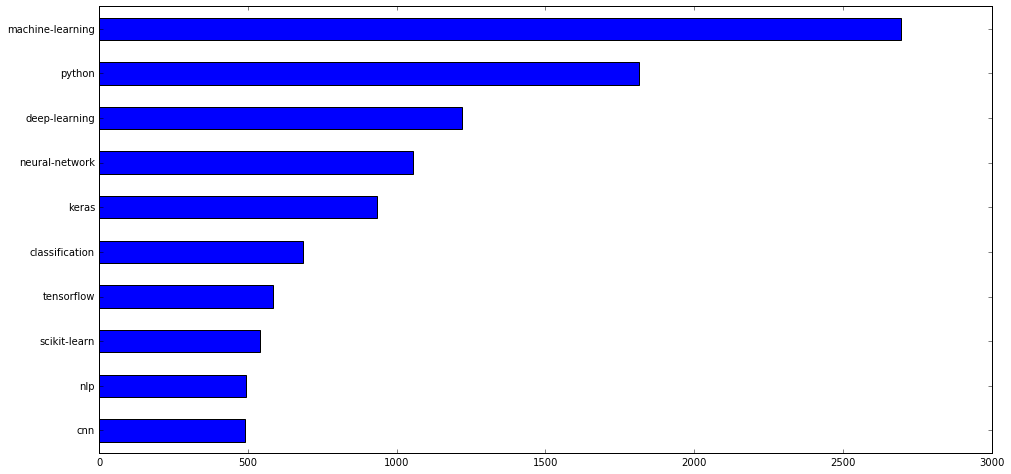

In [11]:
used_df = pd.DataFrame.from_dict(used, orient = 'index')
used_df.rename(columns = {0: 'count'}, inplace = True)
most_used = used_df.sort_values(by = ['count'])
%matplotlib inline
most_used[-10:].plot(kind = 'barh', figsize=(16,8), legend = False)

**Count how many times each was viewed and create visualization for top tags**

[Convert a dictionary from a series](https://careerkarma.com/blog/python-convert-list-to-dictionary/)

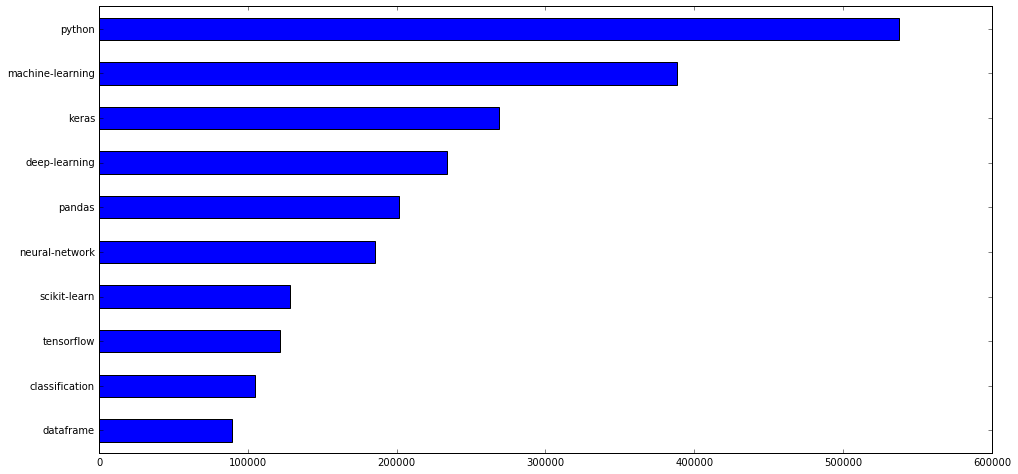

In [12]:
view_keys = list(used_df.index)
views = dict.fromkeys(view_keys,int(0))

for i, r in df.iterrows():
    tags = r[4]
    count = r[3]
    for el in tags:
        views[el] += count
        
views_df = pd.DataFrame.from_dict(views, orient = 'index')
views_df.rename(columns = {0:'count'}, inplace = True)
most_views = views_df.sort_values(by = ['count'])
most_views[-10:].plot(kind = 'barh', figsize = (16,8), legend = False)

**side by side visual for most used and most viewed**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb76ffba710>],
      dtype=object)

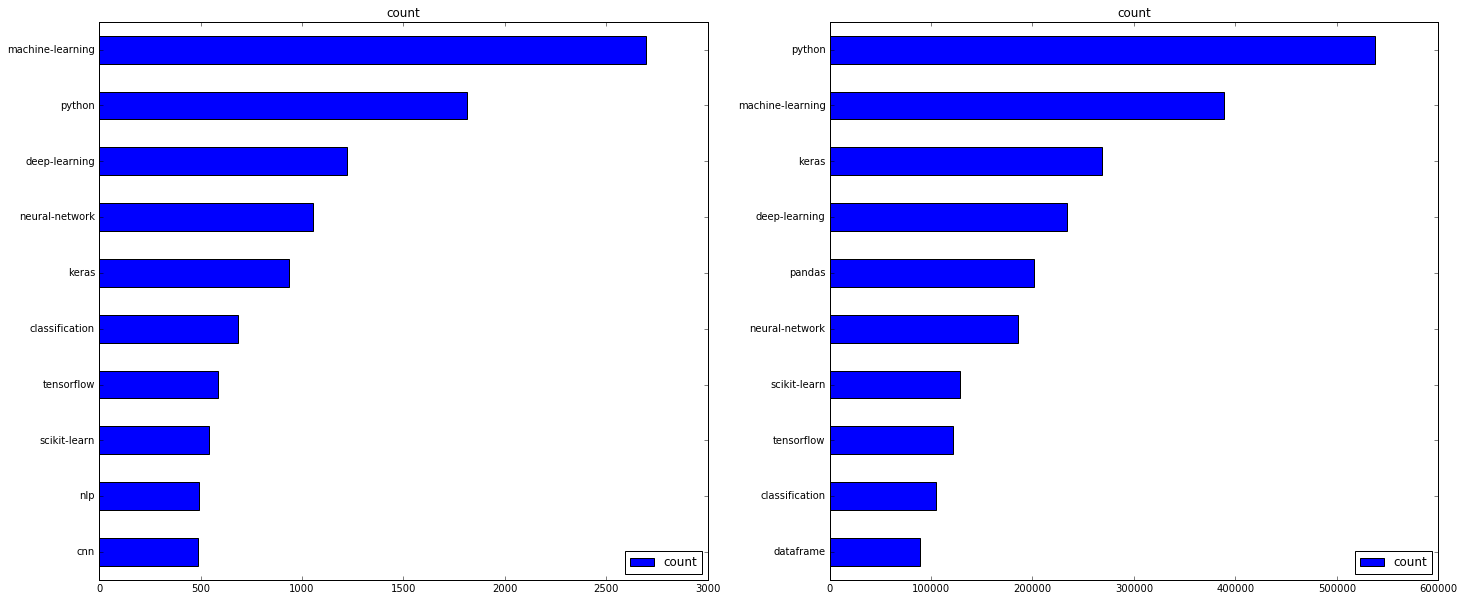

In [13]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2)
fig.set_size_inches((24,10))
most_used[-10:].plot(kind='barh', ax=axes[0], subplots=True)
most_views[-10:].plot(kind='barh', ax = axes[1], subplots=True)

## Part VIII - Relations Between Tags
- Finding relationships between tags i.e. Pandas and python are related as Pandas is a library in Python, however r and python are unrelated
- Note: to find the questions for an entry in the dataframe place the id in https://datascience.stackexchange.com/questions/ID with the questions' Ids values

In [14]:
most_used_merge = pd.merge(most_used[-20:],most_views[-20:],
                          how='left', left_index=True, right_index=True)
most_used_merge

,count_x,count_y
machine-learning-model,224,NaN
statistics,234,NaN
clustering,257,33928.0
predictive-modeling,265,NaN
r,268,NaN
dataset,340,43151.0
regression,347,49451.0
pandas,354,201787.0
lstm,402,74458.0
time-series,466,64134.0


In [15]:
most_views_merge = pd.merge(most_views[-20:], most_used[-20:],
                          how='left', left_index=True, right_index=True)
most_views_merge

,count_x,count_y
clustering,33928,257.0
csv,38654,NaN
pytorch,40240,NaN
dataset,43151,340.0
regression,49451,347.0
numpy,49767,NaN
time-series,64134,466.0
cnn,70349,489.0
nlp,71382,493.0
lstm,74458,402.0


- In order to find relationships between pair of tags one can create a Boolean series of entries that contain both tags and determine a percentile of how many related entries there are compared to the number of total entries. To visualize the relationship a heatmap is helpful
- In order to determine relationships between multiple tags one could do a multivariate plot

In [16]:
most_used_index = most_used.index[::-1]
rel = pd.DataFrame(0, index = most_used_index, columns = most_used_index)
rel

,machine-learning,python,deep-learning,neural-network,keras,classification,tensorflow,scikit-learn,nlp,cnn,...,noisification,nl2sql,summarunner-architecture,pgm,helmert-coding,amazon-ml,haar-cascade,knime,consumerweb,corpus
machine-learning,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
python,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
deep-learning,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
neural-network,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
keras,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
classification,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tensorflow,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
scikit-learn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
nlp,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cnn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
for tags in df.Tags:
    rel.loc[tags,tags] += 1

In [18]:
rel

,machine-learning,python,deep-learning,neural-network,keras,classification,tensorflow,scikit-learn,nlp,cnn,...,noisification,nl2sql,summarunner-architecture,pgm,helmert-coding,amazon-ml,haar-cascade,knime,consumerweb,corpus
machine-learning,2693,499,429,366,195,259,106,188,113,124,...,0,0,0,0,0,0,0,0,0,0
python,499,1814,160,137,280,98,167,235,71,62,...,0,0,0,0,0,0,0,0,0,0
deep-learning,429,160,1220,305,247,59,136,16,72,160,...,0,1,0,0,0,0,0,0,1,0
neural-network,366,137,305,1055,235,65,108,24,24,118,...,0,0,0,0,0,0,0,0,0,0
keras,195,280,247,235,935,58,256,34,23,116,...,0,0,0,0,0,0,0,0,0,0
classification,259,98,59,65,58,685,20,47,35,20,...,0,0,0,0,0,0,0,0,0,0
tensorflow,106,167,136,108,256,20,584,15,11,57,...,0,0,0,0,0,0,0,0,0,0
scikit-learn,188,235,16,24,34,47,15,540,12,0,...,0,0,0,0,0,0,0,0,0,0
nlp,113,71,72,24,23,35,11,12,493,7,...,0,1,0,0,0,0,0,0,0,1
cnn,124,62,160,118,116,20,57,0,7,489,...,0,0,0,0,0,0,0,0,0,0


The dataframe is relatively large, so the focus will be narrowed down the 20 most used tags and add colors to ease reading the dataframe

In [19]:
top_20_index = most_used_index[:20]
rel_20 = rel.loc[top_20_index, top_20_index]
rel_20.shape

(20, 20)

In [20]:
def table_format(table):
    temp_df = pd.DataFrame('',index=table.index, columns=table.columns)
    temp_df.loc['time-series','r'] = 'background-color:yellow'
    temp_df.loc['r','time-series'] = 'background-color:yellow'
    for num in range(temp_df.shape[0]):
        temp_df.iloc[num,num] = 'color:blue'
    return temp_df

rel_20.style.apply(table_format, axis=None)

,machine-learning,python,deep-learning,neural-network,keras,classification,tensorflow,scikit-learn,nlp,cnn,time-series,lstm,pandas,regression,dataset,r,predictive-modeling,clustering,statistics,machine-learning-model
machine-learning,2693,499,429,366,195,259,106,188,113,124,131,71,62,119,99,63,123,61,89,139
python,499,1814,160,137,280,98,167,235,71,62,105,61,244,59,53,24,35,45,35,37
deep-learning,429,160,1220,305,247,59,136,16,72,160,44,103,1,21,32,5,32,2,12,19
neural-network,366,137,305,1055,235,65,108,24,24,118,33,69,1,42,20,9,13,8,11,10
keras,195,280,247,235,935,58,256,34,23,116,51,133,3,31,13,10,11,0,3,17
classification,259,98,59,65,58,685,20,47,35,20,25,20,3,34,28,10,27,12,19,21
tensorflow,106,167,136,108,256,20,584,15,11,57,9,43,3,9,9,1,6,0,0,9
scikit-learn,188,235,16,24,34,47,15,540,12,0,12,2,37,37,9,1,12,24,6,18
nlp,113,71,72,24,23,35,11,12,493,7,0,19,3,2,11,4,1,9,3,4
cnn,124,62,160,118,116,20,57,0,7,489,8,24,1,6,11,2,6,0,1,4


Although this is quantitatively helpful, it is a lot of imformation and a [heatmap](https://seaborn.pydata.org/examples/many_pairwise_correlations.html) will be a great visual to get a better understanding of the relationships between tags. Before creating the heatmap the values in blue, or the ones that are related to itself, should be removed

In [21]:
for i in range(rel_20.shape[0]):
    rel_20.iloc[i,i] = pd.np.NaN

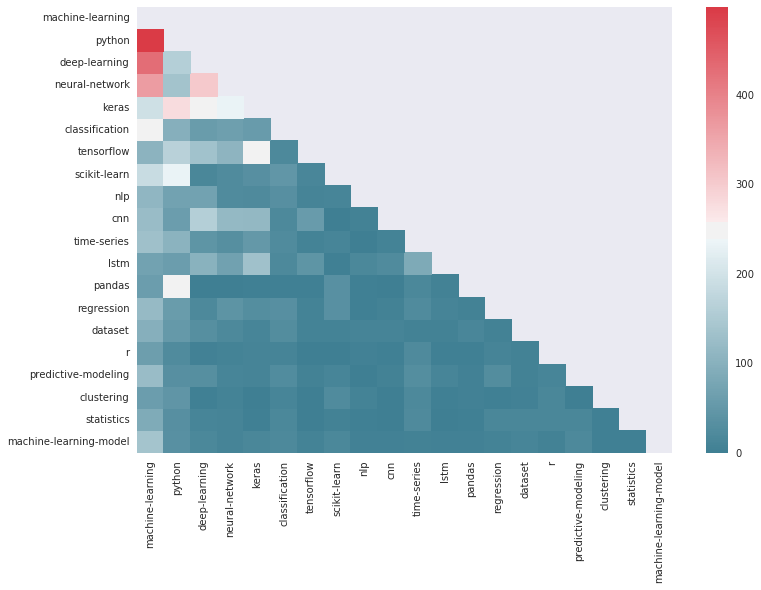

In [22]:
import seaborn as sns
import numpy as np
plt.figure(figsize=(12,8))

corr = rel_20.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(rel_20, annot=False, mask=mask, cmap=cmap)

The downside to determining only two variables is that it neglects relations between multiple gorups of tags. For example x1 and x2 when together can be strongly correlated to x3, however x1 and x2 by itself does not have a strong relationship with x3.

To tackle this short one can use the [association rule](https://en.wikipedia.org/wiki/Association_rule_learning) which not only spots relations but can measure the how strong the relation is, how common the relation is and how independent the variables within the relation are. The idea of independence between features within a relationship is known as [statistical independence](https://en.wikipedia.org/wiki/Independence_(probability_theory))

## Part IX - Enter Domain Knowledge
- Although analytical solutions to the problem exist, sometimes the best way to solve the problem is [domain knowledge](https://en.wikipedia.org/wiki/Domain_knowledge)
- The most used tags are also the most viewed. From the top 10 tags of each, the common list is: python, machine-learning, deep-learning, neural-network, keras, tensorflow, classification, scikit-learn

**examine the [tags page on DSSE](https://datascience.stackexchange.com/tags) and see if by understanding the tags meaning there could be a strong relation between them**
- Using domain knowledge the central theme to be deep learning and the rest of the tags seem to be intimately related to it. It seems that the idea is or relates to the making of Python content that takes classification problems using deep learning
- [Keras](https://keras.io/), [scikit-learn](https://scikit-learn.org/stable/), [TensorFlow](https://www.tensorflow.org/) are all Python libraries that enable users to employ deep learning which is a type of neural network

## Part X - Just a Fad?
- Before officiall declaring a recommendation, it would be nice to solidify the findings with more proof. More specifically, answering the question "is deep learning just a fad?" Ideally, the content created will be useful for as long as possible
- In order th tackle this problem, a file was imported that is extracted from a query that selects the Id, CreationDate and Tags from all the questions ever asked on DSSE
- Here, the interest in deep learning across time will be tracked. The track will include:
    - The number of deep learning questions asked per time period
    - The total amount of questions per time period
    - The number of deep learning questions relative to the total number of questions asked per time period
    
**Read the file all_questions.csv into a dataframe**

In [23]:
allq = pd.read_csv('all_questions.csv', parse_dates = ['CreationDate'])
allq.head()

,Id,CreationDate,Tags
0,45416,2019-02-12 00:36:29,<python><keras><tensorflow><cnn><probability>
1,45418,2019-02-12 00:50:39,<neural-network>
2,45422,2019-02-12 04:40:51,<python><ibm-watson><chatbot>
3,45426,2019-02-12 04:51:49,<keras>
4,45427,2019-02-12 05:08:24,<r><predictive-modeling><machine-learning-mode...


**Transform the tags column in a similar manner to what was previously done**

In [24]:
allq['Tags'] = allq['Tags'].str.replace('^<|>$','').str.split('><')
allq.sample(3)

,Id,CreationDate,Tags
6889,27491,2018-02-05 17:09:19,"[python, classification, binary]"
6723,40192,2018-10-25 03:06:36,"[clustering, dimensionality-reduction]"
13243,62071,2019-10-22 11:23:36,"[machine-learning, scikit-learn, time-series, ..."


**Identify what questions should be classified as deep learning questions and then implement that definition**
- Questions that are classified as deep learning questions should have tags related to deep learning
    - These tags will be obtained by observing the tags most related to deep learning as well as domain knowledge

In [25]:
rel_20['deep-learning'].sort_values(ascending=False)

machine-learning          429.0
neural-network            305.0
keras                     247.0
cnn                       160.0
python                    160.0
tensorflow                136.0
lstm                      103.0
nlp                        72.0
classification             59.0
time-series                44.0
dataset                    32.0
predictive-modeling        32.0
regression                 21.0
machine-learning-model     19.0
scikit-learn               16.0
statistics                 12.0
r                           5.0
clustering                  2.0
pandas                      1.0
deep-learning               NaN
Name: deep-learning, dtype: float64

- Here, questions that are classified as deep learning questions will contain a tag or tags in the following list: ['lstm', 'cnn', 'scikit-learn', 'tensorflow', 'keras', 'neural-network', 'deep-learning']
- This definition will be implemented by assigning 1 to deep learning questions and 0 to others

In [26]:
def dl(tags):
    for tag in tags:
        if tag in ['lstm', 'cnn', 'scikit-learn', 'tensorflow', 'keras', 'neural-network', 'deep-learning']:
            return 1
    return 0

In [27]:
allq['DeepLearning'] = allq['Tags'].apply(dl)
allq.sample(5)

,Id,CreationDate,Tags,DeepLearning
20259,34189,2018-07-09 10:57:20,"[deep-learning, loss-function, recurrent-neura...",1
15098,22916,2017-09-09 12:37:02,"[machine-learning, statistics]",0
15107,22957,2017-09-11 18:03:47,"[python, statistics, pandas]",0
16609,31991,2018-05-22 14:50:53,"[tensorflow, multiclass-classification, multil...",1
10711,29409,2018-03-22 09:02:20,[reinforcement-learning],0


**Decide on an adequate timeframe and track interest in deep learning across that timeframe**
- The data science technology landscape does not change at a fast pace and therefore a quarterly track will be adequate
- The data starts in 2020, but is cut off before the first quarter and therefore dates in 2020 will be removed
- Will use [floor division](https://python-reference.readthedocs.io/en/latest/docs/operators/floor_division.html)

In [28]:
allq = allq[allq['CreationDate'].dt.year < 2020]

In [29]:
def def_quarter(datetime):
    year = str(datetime.year)[-2:]
    quarter = str((datetime.month-1)//3+1)
    return '{}Q{}'.format(year, quarter)

In [30]:
allq['quarter'] = allq['CreationDate'].apply(def_quarter)
allq.sample(5)

,Id,CreationDate,Tags,DeepLearning,quarter
16527,23638,2017-10-09 14:20:54,"[machine-learning, data-mining, text-mining, w...",0,17Q4
13575,52246,2019-05-20 09:46:42,"[machine-learning, rnn]",0,19Q2
2562,38083,2018-09-11 06:38:03,"[python, pandas, visualization]",0,18Q3
12235,20594,2017-07-21 11:19:48,"[machine-learning, predictive-modeling, recomm...",0,17Q3
5424,26854,2018-01-20 10:25:00,"[machine-learning, neural-network, deep-learni...",1,18Q1


**Count of how many deep learning questions are asked per time period and total amount of questions per time period**

In [31]:
per_time = allq.groupby('quarter').agg({'DeepLearning':['sum','size']})
per_time.columns = ['dl','total']
per_time.head()

,dl,total
quarter,,
14Q2,9,157
14Q3,13,189
14Q4,21,216
15Q1,18,190
15Q2,28,284


**Number of deep learning questions there are relative to the total amount of questions per time period**

In [ ]:
per_time['rate'] = per_time['dl']/per_time['total']
per_time.reset_index(inplace=True)
per_time.head()

,quarter,dl,total,rate
0,14Q2,9,157,0.057325
1,14Q3,13,189,0.068783
2,14Q4,21,216,0.097222
3,15Q1,18,190,0.094737
4,15Q2,28,284,0.098592


**Observations and final recommendation**

In [ ]:
ax1 = per_time.plot(x='quarter',y='rate',kind='line',
                   linestyle='-',marker='o',color='orange',
                   figsize=(24,12))
ax2 = per_time.plot(x='quarter',y='rate',kind='bar',
                   ax=ax1, secondary_y=True,alpha=0.7,
                   rot=45)
for i, v in per_time['total'].iteritems():
    ax2.text(i, v, str(v), ha='center', va='bottom')

ax1.get_legend().remove()

handles1, labels1 = ax1.get_legend_handles_lables()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles = handles1 + handles2,
          labels = labels1 + labels2,
           loc='upper left', prop={'size':12})

for ax in (ax1, ax2):
    for where in ('top','right'):
        ax.spines[where].set_visible(False)
        ax.tick_params(right=False, labelright=False)

AttributeError: 'AxesSubplot' object has no attribute 'get_legend_handles_lables'

It appears that the interest in deep learning has grown over the 5 years DSSE has existed. Although there is no information forcasting whether the interest in deep learning will fall the steady rise is promising and therefore the recommendation to create content on deep learning maintains

## Part XI - Next Steps
The work above has conclude that deep learning is the most popular topic right now. Other factors to consider are:
- What other content can be recommended that isn't as popular? One approach is using association rules to find strong relations between tags.
- What other popularity features could be included in the analysis? Perhaps scores and favourite counts?
The focus here is on DSSE, what other related sites can be used to help achieve the goal?
How can other sites be leveraged to determine what non-data-science content to write about? For example, is there some mathematical field that leads to more questions than others?